**Import Libraries**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

#### Pretrained Model

A pretrained model refers to a machine learning model that has already been trained on a large dataset, typically for a specific task, and is ready for use or fine-tuning on a new task or dataset. The key idea behind a pretrained model is that it has already learned useful patterns or features from the data it was trained on, so you don’t need to start from scratch.

- **ResNet, VGG (Image Classification):** These are pretrained models commonly used for image classification tasks. They have learned from millions of images and can be fine-tuned for specific image-related tasks.

- **BLIP (Image Captioning and Summarization):** BLIP is a pretrained model that can generate captions and summaries for images. It has already been trained on image-text pairs, so it can easily generate descriptive captions for new images.


## <a id='toc1_'> </a> [Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'](#toc1_) 

### <a id='toc1_1_'></a> [1.1 Dataset Preparation](#toc1_) 

The first step is to load and prepare the dataset of aircraft images. These images are labeled either as 'dent' or 'crack'. We will also split the dataset into training, validation, and test sets.

Your goal is to train an algorithm on these images and to predict the labels for images in your test set.




**Setting batch_size, epochs and image_size**

In [47]:
batch_size = 32
epochs = 5
image_rows = 224
image_cols = 224
input_shape = (image_rows, image_cols, 3)

**Extract the Dataset:**
Unzip the dataset to the current directory, creating directories for training, testing, and validation splits.


In [48]:
import tarfile
import urllib.request
import shutil
import os

In [49]:
# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

**Defining path for downloading file**

In [50]:
tarfile_name = 'aircraft_damage_dataset_v1.tar'
extracted_folder = 'aircraft_damage_dataset_v1' # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tarfile_name)
print(f'Downloaded {tarfile_name}. Extraction will begin now')

Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now


**Checing if folder already exist and if exist delete the folder**

In [51]:
# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f'The folder {extracted_folder} already exist. Removing the existing folder')

    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f'Successfully deleted existing {extracted_folder}.')

The folder aircraft_damage_dataset_v1 already exist. Removing the existing folder
Successfully deleted existing aircraft_damage_dataset_v1.


**Extracting .tar file to the give folder**

In [52]:
with tarfile.open(tarfile_name, 'r') as tar_ref:
    tar_ref.extractall()    # This will extract to the current directory
    print(f'Extracted {tarfile_name} successfully!!')

Extracted aircraft_damage_dataset_v1.tar successfully!!


**Define directories for train, validation, and test sets**

In [53]:
train_dir = os.path.join(extracted_folder, 'train')
test_dir = os.path.join(extracted_folder, 'test')
valid_dir = os.path.join(extracted_folder, 'valid')

## 1.2 Data Preprocessing

Create data generators for training, validation, and testing datasets.

First,we will create ImageDataGenerators used for training, validation and testing.
The ImageDataGenerator class is part of Keras. It is a powerful utility for real-time image data augmentation, preprocessing, and feeding data into deep learning models during training. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset  to improve model generalization. 

We will create instances of the ImageDataGenerator class. Each instance corresponds to one of the datasets: training, validation, and testing.


In [54]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

Next, we use flow_from_directory() method to load the images from directory and generate the training dataset. The flow_from_directory() method is part of the ImageDataGenerator class in Keras, and it plays a crucial role in automating the process of loading, preprocessing, and batching images for training, validation, and testing.
We use the train_datagen object to load and preprocess the training images. Specifically, the flow_from_directory() function is used to read images directly from the directory and generate batches of data that will be fed into the model for training.


In [55]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    target_size=(image_rows, image_cols),
                                                    seed=42,
                                                    class_mode = 'binary',
                                                    shuffle=True)

Found 300 images belonging to 2 classes.


In [71]:
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=batch_size,
                                                    target_size=(image_rows, image_cols),
                                                    seed=42,
                                                    class_mode='binary',
                                                    shuffle=True)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  target_size=(image_rows, image_cols),
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode='binary')

Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## 1.3 Model Definition

Here, we define the model architecture by using a pre-trained VGG16 model as the base, adding custom layers on top for binary classification of 'dent' and 'crack' types of damage.


## **Task 3: Load the pre-trained model VGG16**

Set <code>weights='imagenet'</code>,<code>include_top=False</code>,<code>input_shape=(img_rows, img_cols, 3)</code>

Hint: The format should be like:

base_model = VGG16(weights= , include_top= , input_shape=)

****Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission****


In [72]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=input_shape)

**Checking the layers of *base_model***
* Following are the layers of the pretrained model i.e. VGG16
* List of the layers used in the pre trained model

In [73]:
base_model.layers

* Lets access the last layer in the base_model using ***base_model.layers[-1]***
* Then we will get the **output** of that layer using **base_model.layers[-1].output**

In [74]:
output = base_model.layers[-1].output

* Lets flatten the last node i.e. if last node has output of **(7, 7, 512)**, then *Flatten()* will do **7 * 7 * 512=25088**

In [75]:
output = Flatten()(output)

**Create new base_model**

Now, we modify the VGG16 model for our specific classification task. We extract the output from the last layer of the pre-trained VGG16 model, and then create a new model with this modified output. Then we will freeze the base VGG16 model layers so that their weights will not be updated during training.


In [76]:
base_model = Model(base_model.input, output)
# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. This involves adding fully connected layers (Dense), activation functions (like ReLU), and sometimes Dropout layers to avoid overfitting.
Here, we are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").


**Build custom model**

In [77]:
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## **Task 4: Compile the model**

You will compile the model using the following parameters:

*   **loss**: `'binary_crossentropy'`.
*   **optimizer**: `=Adam(learning_rate=0.0001)`.
*   **metrics**: `['accuracy']`.

Hint: Use `model.compile()` to compile the model:
    
```python
model.compile(
    optimizer=,
    loss=,
    metrics=
)
```
**Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission.**


In [78]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Task 5: Model Training
Now that the model is compiled, you can train it using the .fit() method. This step involves passing in the training and validation datasets along with the number of epochs you want to train the model for.

We will train the model using the following parameters:

*   **train_data**: `train_generator`
*   **epochs**: `n_epochs`
*   **validation_data**: `valid_generator`

Hint: Use `model.fit()` to train the model:
    
```python
history = model.fit(
    <train_data>,  # Fill in with the training data generator or dataset
    epochs=<number_of_epochs>,  # Fill in with the number of epochs for training
    validation_data=<validation_data>,  # Fill in with the validation data generator or dataset
   
)

```
**Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission**


In [79]:
history = model.fit(train_generator, 
                    epochs=epochs,
                    validation_data=valid_generator,
                    batch_size=batch_size)

Epoch 1/5


2025-05-25 13:40:09.281452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


10/10 [==============================] - 5s 482ms/step - loss: 1.2062 - accuracy: 0.5100 - val_loss: 1.2204 - val_accuracy: 0.5000
Epoch 2/5
10/10 [==============================] - 4s 452ms/step - loss: 0.8885 - accuracy: 0.6233 - val_loss: 0.7361 - val_accuracy: 0.6042
Epoch 3/5
10/10 [==============================] - 4s 452ms/step - loss: 0.6205 - accuracy: 0.7067 - val_loss: 0.6079 - val_accuracy: 0.6458
Epoch 4/5
10/10 [==============================] - 4s 451ms/step - loss: 0.5343 - accuracy: 0.7767 - val_loss: 0.6842 - val_accuracy: 0.6250
Epoch 5/5
10/10 [==============================] - 4s 452ms/step - loss: 0.4184 - accuracy: 0.8233 - val_loss: 0.7436 - val_accuracy: 0.6354


In [80]:
# Accessing the history
train_history = model.history.history
train_history

{'loss': [1.2061597108840942,
  0.8884521722793579,
  0.6205030083656311,
  0.5343383550643921,
  0.418448805809021],
 'accuracy': [0.5099999904632568,
  0.6233333349227905,
  0.7066666483879089,
  0.7766666412353516,
  0.8233333230018616],
 'val_loss': [1.220396637916565,
  0.7360541224479675,
  0.6079489588737488,
  0.6842401027679443,
  0.7436323165893555],
 'val_accuracy': [0.5,
  0.6041666865348816,
  0.6458333134651184,
  0.625,
  0.6354166865348816]}

## 1.5 Visualizing Training Results

- After training the model, we visualize the training and validation accuracy and loss to understand the model's learning process.


**Training and Validation Loss plot**

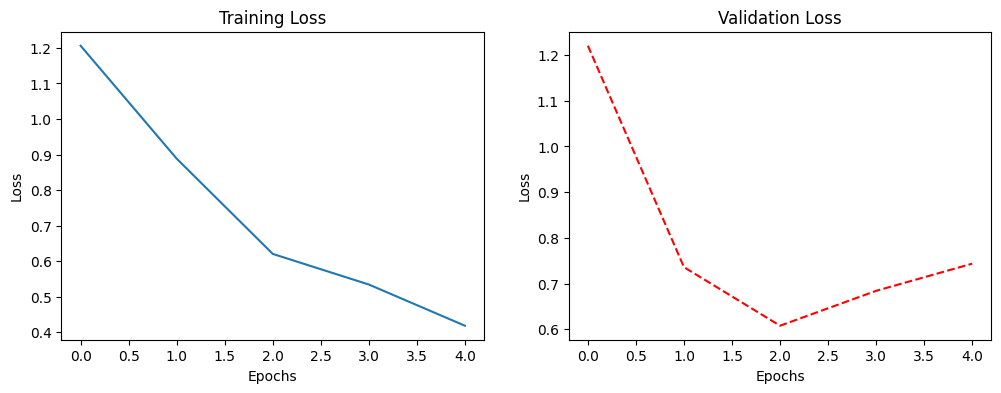

In [81]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax_0.set_title('Training Loss')
ax_0.plot(model.history.history['loss'])
ax_0.set_xlabel('Epochs')
ax_0.set_ylabel('Loss')

ax_1.plot(model.history.history['val_loss'], ls='--', color='red')
ax_1.set_xlabel('Epochs')
ax_1.set_ylabel('Loss')
ax_1.set_title('Validation Loss')
plt.show()

**Training and Validation accuracy plot**

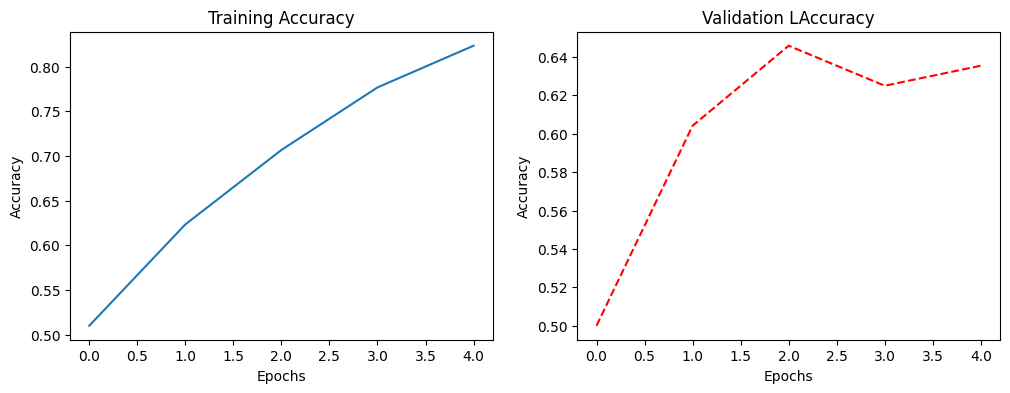

In [82]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax_0.set_title('Training Accuracy')
ax_0.plot(model.history.history['accuracy'])
ax_0.set_xlabel('Epochs')
ax_0.set_ylabel('Accuracy')

ax_1.plot(model.history.history['val_accuracy'], ls='--', color='red')
ax_1.set_xlabel('Epochs')
ax_1.set_ylabel('Accuracy')
ax_1.set_title('Validation LAccuracy')
plt.show()

## 1.6 Model Evaluation

Now we evaluate the trained model on the test dataset. Calculates test loss and accuracy by evaluating the test generator. Predictions are made for the test dataset, and the results are compared to true labels.


In [145]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples//test_generator.batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_accuracy:.2f}%')

1/1 [==============================] - 1s 573ms/step - loss: 0.7234 - accuracy: 0.6250
Test Loss: 0.7234
Test Accuracy: 62.50%


In [146]:
# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, pred_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]
    pred_label_name = class_names[pred_label]

    plt.title(f'True: {true_label_name}\nPred: {pred_label_name}')
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions>0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v:k for k, v in class_indices.items()}

    # Specify the image to display based on the index
    images_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=images_to_plot, model=model, true_label=true_label, pred_label=predicted_label, class_names=class_names)

## **Task 7: Visualizing the results**

In this task, you will specify which image from the test dataset to display and test the model on. You will fill in the required values to test your model.

You will visualize using the following parameters:

*   **test_data_generator**: `test_generator`.
*   **model**: `model`.
*   **index_to_plot**: `1`.

Hint: Use `test_model_on_image` to visualize the result:
    
```python
test_model_on_image(<test_data_generator>, <model>, index_to_plot=index_to_plot)

```
**NOTE**: Due to the inherent nature of neural networks, predictions may vary from the actual labels. For instance, if the actual label is ‘crack’, the prediction could be either ‘crack’ or ‘dent’, both of which are possible outcomes, and full marks will be awarded for the task.            


1/1 [==============================] - 0s 15ms/step


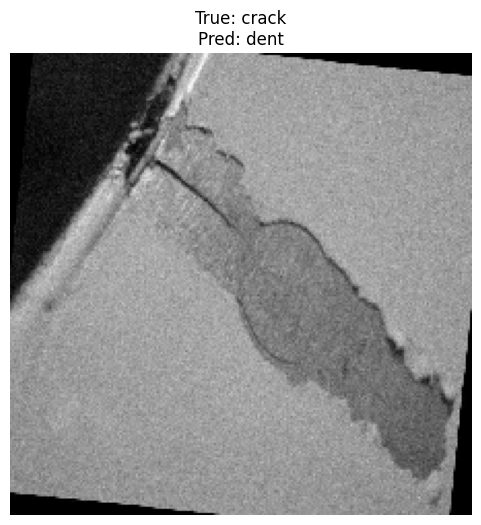

In [149]:
test_data_generator = test_generator
model = model
index_to_plot = 11
test_model_on_image(test_generator=test_data_generator,
                    model=model,
                    index_to_plot=index_to_plot)

### **How to plot images with title in batch**

In [143]:
# Function to plot a single image and its prediction
def plot_image_with_title_(image, model, true_label, pred_label, class_names):
    plt.figure(figsize=(16, 16))
    for i in range(image.shape[0]):
        plt.subplot(5, 7, i+1)
        plt.imshow(image[i])

        # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
        true_label_name = class_names[int(true_label[i])]
        pred_label_name = class_names[int(pred_label[i])]

        plt.title(f'True: {true_label_name}\nPred: {pred_label_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image_(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions>0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v:k for k, v in class_indices.items()}

    # Plot the selected image with its true and predicted labels
    plot_image_with_title_(image=test_images, model=model, true_label=test_labels, pred_label=predicted_classes, class_names=class_names)

1/1 [==============================] - 0s 20ms/step


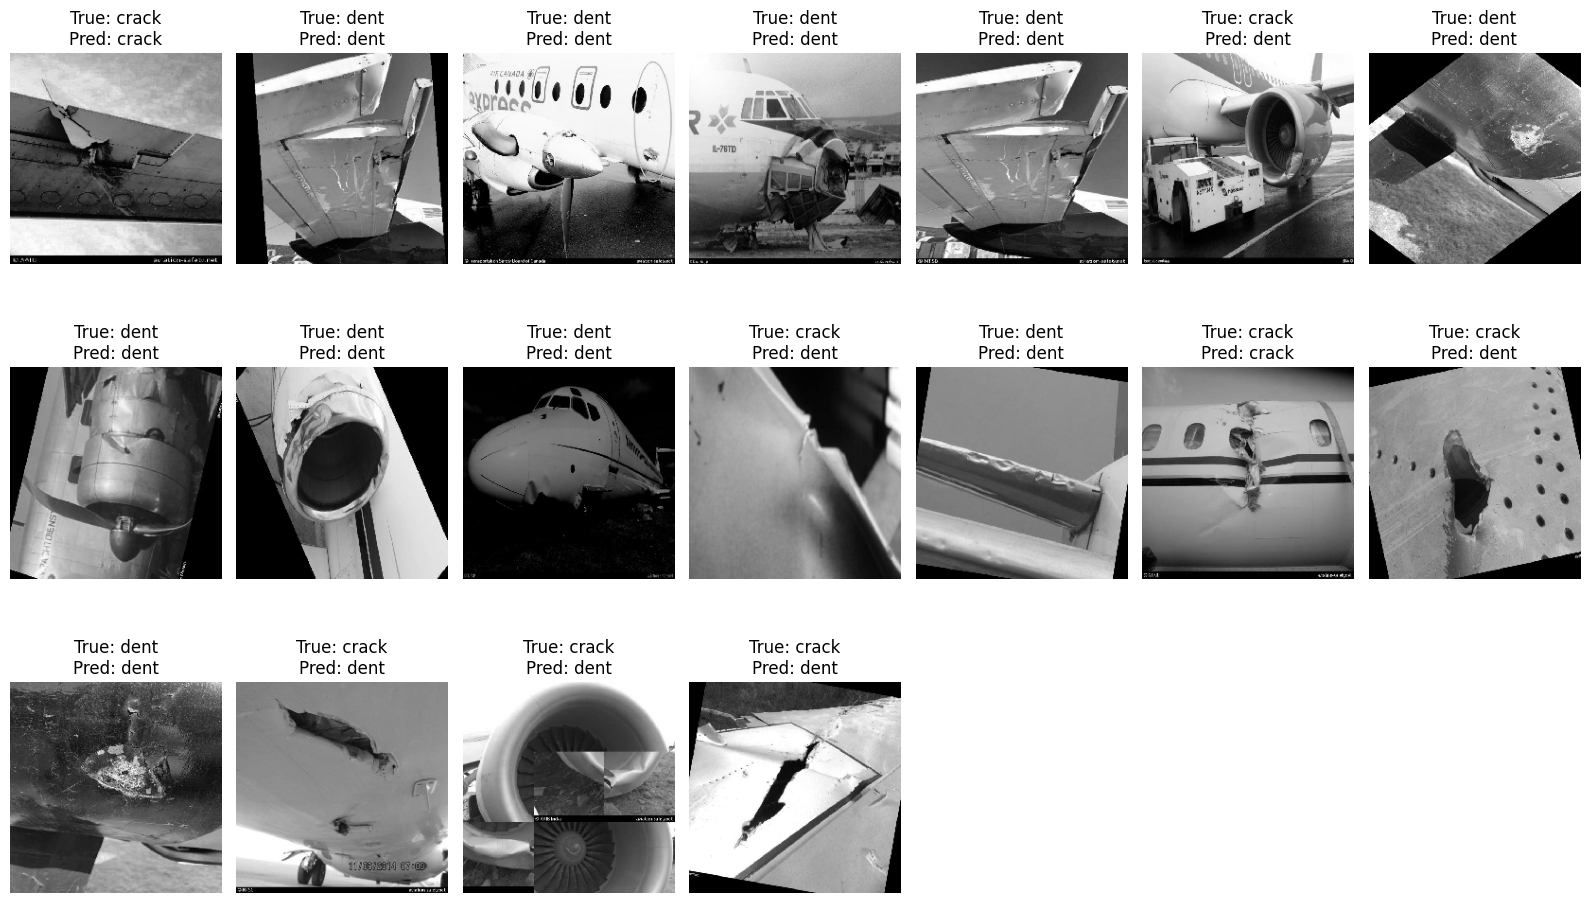

In [144]:
test_data_generator = test_generator
model = model
test_model_on_image_(test_generator=test_data_generator,
                    model=model)

## <a id='toc2_'></a>[Part 2: Image Captioning and Summarization using BLIP Pretrained Model](#toc2_)


BLIP (Bootstrapping Language-Image Pretraining) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

In this project, learners will utilize the BLIP model to build a system capable of automatically generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.


#### Key Steps:

- **Image Loading and Preprocessing:** The code will begin by loading images from a file path, then converting and processing them into a format suitable for input to the BLIP model.
  
- **Text Generation:** Depending on the task, whether generating a caption or summary, the BLIP model will generate corresponding text based on the processed image.
  
- **Custom Keras Layer:** A custom Keras layer is a user-defined layer that extends Keras' built-in functionality.Here custom Keras layer will be implemented to wrap the BLIP model. This layer will handle the task-specific processing (captioning or summarizing) and integrate smoothly into a TensorFlow/Keras environment.


### **Hugging Face**</br>
Hugging face is a company or eco-system that host several libraries related to computer vision, audio, text generation, and speech related AI domain. It has lots of libraries like **transformers**, **BLIP (Bootstrapped Language-Image Pretraining)**, and many more

In [151]:
import torch 
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

## 2.1 Loading BLIP Model


#### Load the BLIP Model and Processor from Hugging Face

Hugging Face is an open-source platform that provides pre-trained machine learning models, datasets, and tools, primarily focused on natural language processing, computer vision, and other AI tasks. It offers easy access to powerful models through its Transformers library.

- **BlipProcessor:** This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

- **BlipForConditionalGeneration:** This is the model itself, responsible for generating captions or summaries based on the processed image.


In [153]:
processor = BlipProcessor.from_pretrained('Salesforce/blip-image-captioning-base')
model = BlipForConditionalGeneration.from_pretrained('Salesforce/blip-image-captioning-base')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

#### Custom Keras Layer: BlipCaptionSummaryLayer

Next, we define a custom `tf.keras.layers.Layer` class that takes in an image and a task input (either caption or summary) and processes the image using the BLIP model. To create a custom Keras layer, we need to subclass `tf.keras.layers.Layer` and implement the required methods.

#### **BlipCaptionSummaryLayer Class:**

This custom Keras layer integrates image preprocessing and text generation using a pretrained BLIP model.

- **`__init__`**: This constructor method initializes the `BlipCaptionSummaryLayer` class by setting up the BLIP processor and model.
  
- **`call`**: This method defines the operations or transformations applied to the input data as it passes through the layer.

- **`process_image`**: The `process_image` method contains the custom logic for loading the image, preprocessing it, generating the text (either a caption or a summary) using the BLIP model, and returning the generated result.


In [199]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model
    
    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)    # py_function() requires 3 parameters (function, input, output)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode('utf-8')

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert('RGB')

            # Set the appropriate prompt based on the task
            if task.numpy().decode('utf-8')=='caption':
                prompt = "This is a picture of" # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary
            
            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors='pt')   # return_tensors='pt' is torch tensors

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f'Error {e}')
            return 'Error Processing Image'

**Example**: Use of ***py_function()***

In [200]:
def add_xy(x, y):
    return x+y
x = tf.constant(3)  # Getting tensors
y = tf.constant(5)
tf.py_function(add_xy, [x, y], tf.int32)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

## Task 8: Implement a Helper Function to Use the Custom Keras Layer

In this task, you will implement a helper function `generate_text` that utilizes the custom `BlipCaptionSummaryLayer` Keras layer to generate captions or summaries for a given image. The function will accept an image path and a task type (caption or summary), process the image using the BLIP model, and return the generated text.

### **Steps:**

#### Create the Helper Function `generate_text`:
The function will accept following parameters:

* **`image_path`**: The path to the image file (in tensor format).
* **`task`**: The type of task to perform, which can either be "caption" or "summary" (in tensor format).
  
Inside the function:
1. Create an instance(blip_layer) of the `BlipCaptionSummaryLayer`.
2. Call this layer with the provided image path and task type.
3. Return the generated caption or summary as the output.

In [201]:
def generate_text(image_path, task):
    blip_layer = BlipCaptionSummaryLayer(processor=processor, model=model)
    return blip_layer(image_path, task)

## 2.2 Generating Captions and Summaries

Now we use the `generate_text` function to generate a caption and a summary for an image.
It processes the image and prints the corresponding text output in a human-readable format.
The function makes it easy to switch between generating captions and summaries based on the task type you provide.</br>
</br>

**Note:** Generated captions/summary may not always be accurate, as the model is limited by its training data and may not fully understand new or specific images.



**Getting Image Path from directory**

In [223]:
path_ = 'aircraft_damage_dataset_v1/test/dent/'
names = os.listdir(path_)
file_path = [os.path.join(path_, f_name) for f_name in names]
file_path_ = file_path[3]

In [221]:
image_path = tf.constant(file_path_)

# Generate caption for the image
caption = generate_text(image_path=image_path, task=tf.constant('caption'))
# Decode and print the caption
print(f'Caption: {caption.numpy().decode("utf-8")}')

# Generate summary for the image
summary = generate_text(image_path=image_path, task=tf.constant('summary'))
# Decode and print summary
print(f'Summary: {summary.numpy().decode("utf-8")}')

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the nose of a boeing 747


## Task 9: Generate a caption for an image using the using BLIP pretrained model

- Use the image_path variable given below to load the image. Run the cell to before proceeding to next step.
- Use the `generate_text` function to generate a caption for the image.
- Use the example given in `2.2 Generating Captions and Summaries` for this task
  
**Note:** Generated captions may not always be accurate, as the model is limited by its training data and may not fully understand new or specific images.


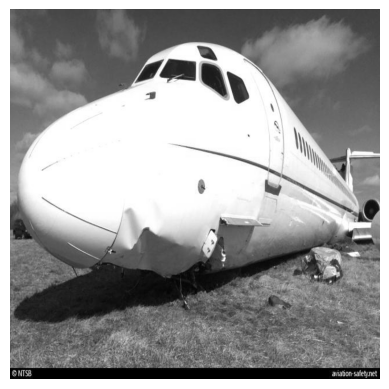

In [226]:
image_path = file_path_
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [228]:
caption=generate_text(image_path, tf.constant('caption'))
print(f'Caption: {caption.numpy().decode("utf-8")}')

Caption: this is a picture of a plane that was sitting on the ground in a field


## Task 10: Generate a summary of an image using BLIP pretrained model

- Use the image_path variable given below to load the image. Run the cell before proceeding to next step.
- Use the `generate_text` function to generate a caption for the image.
- Use the example given in `2.2 Generating Captions and Summaries` for this task

**Note:** Generated summary may not always be accurate, as the model is limited by its training data and may not fully understand new or specific images.


In [230]:
summary=generate_text(image_path, tf.constant('summary'))
print(f'Summary: {summary.numpy().decode("utf-8")}')

Summary: this is a detailed photo showing the damage to the fuselage of the aircraft
